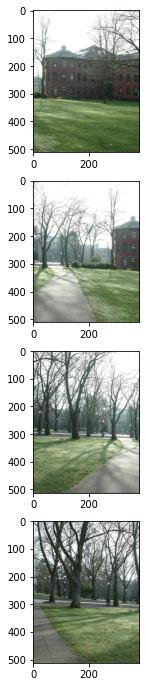

In [16]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

focal_len = 705
path = "./data/parrington/prtn*.jpg"
files = glob.glob(path)
files.sort(reverse=False)
images = [cv2.imread(f) for f in files][:4]

plt.figure(figsize=(12,12))
for i in range(len(images)):
    plt.subplot(4, math.ceil(len(images)/4), i+1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))

In [17]:
def warp(image):
    result_width = round(math.atan(image.shape[1]/2/focal_len) * focal_len * 2)
    result_height = image.shape[0]
    origin_center_x = (image.shape[1]-1) / 2
    origin_center_y = (image.shape[0]-1) / 2

    result_center_x = (result_width-1) / 2
    result_center_y = (result_height-1) / 2

    # print(image.shape[1], image.shape[0])

    # print(result_width, result_height)

    def project_pixel(i, j):
        theta = (i - result_center_x)/focal_len
        h = j - result_center_y

        #print(i)
        # print(origin_center_x)
        x = round(focal_len * math.tan(theta) + origin_center_x)
        y = round(h / math.cos(theta) + origin_center_y)

        if x < 0 or y < 0 or x >= image.shape[1] or y >= image.shape[0]:
            return np.zeros(3)
        else:
            return image[y][x]

    result_image_idx = np.ndindex((result_height, result_width))
    result_image = np.array([project_pixel(j, i) for i, j in result_image_idx])
    return result_image.astype(np.uint8).reshape(result_height, result_width, 3)
    #return np.fromfunction(lambda i, j: project_pixel(i, j), (result_width, result_height), dtype=int)

In [3]:
# s = focal_len
# def warp_image(image):
#     result_image = np.zeros((image.shape[0], image.shape[1], 3))
#     center_y = image.shape[0] // 2
#     center_x = image.shape[1] // 2
#     def project_pixel(y, x):
#         now_y, now_x = y-center_y, x-center_x
#         h = now_y / math.sqrt(now_x**2 + focal_len**2) * s
#         theta = math.atan(now_y/focal_len) * s
#         result_image[round(center_y+h)][round(center_x+now_x)] = image[y][x]
    
#     result_image_idx = np.ndindex((image.shape[0], image.shape[1]))
#     [project_pixel(i,j) for i,j in result_image_idx]
#     return result_image.astype(np.uint8)
# img_warp = warp_image(images[0])
# plt.imshow(img_warp)

<Figure size 432x288 with 0 Axes>

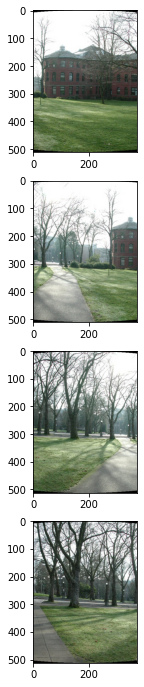

In [18]:
result_images = [warp(img) for img in images]

plt.clf()
plt.figure(figsize=(12,12))
for i in range(len(result_images)):
    plt.subplot(4, math.ceil(len(result_images)/4), i+1)
    plt.imshow(cv2.cvtColor(result_images[i], cv2.COLOR_BGR2RGB))

## Detection

In [19]:
def harris(gray_img, ksize, gksize, k):
    gray_img = np.float64(gray_img)
    dx = cv2.Scharr(gray_img, cv2.CV_64F, 1, 0, ksize)
    dy = cv2.Scharr(gray_img, cv2.CV_64F, 0, 1, ksize)
    
    Ixx = cv2.multiply(dx, dx)
    Iyy = cv2.multiply(dy, dy)
    Ixy = cv2.multiply(dx, dy)
    
    Sxx = cv2.GaussianBlur(Ixx, (gksize, gksize), 0)
    Syy = cv2.GaussianBlur(Iyy, (gksize, gksize), 0)
    Sxy = cv2.GaussianBlur(Ixy, (gksize, gksize), 0)

    det = Sxx * Syy - Sxy * Sxy
    trace = Sxx + Syy
    R = det - k * cv2.multiply(trace, trace)

    orientation = np.arctan2(dy, dx)
    orientation[orientation == math.pi] = -math.pi
    
    return R, orientation

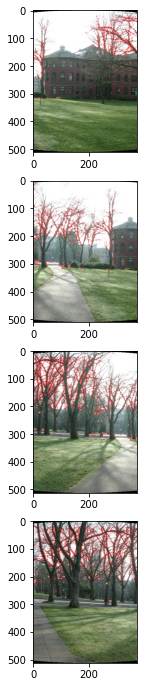

In [20]:
ksize = 3
gksize = 3
k = 0.05
threshold = 1
gray_images = []
harris_images = []
key_points_all = []
orientations = []

plt.figure(figsize=(12,12))
for i, img in enumerate(result_images):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_images.append(gray_img)
    
    harris_img, orientation = harris(gray_img, ksize, gksize, k)
    orientations.append(orientation)
    
    # dilate_img = cv2.dilate(harris_img, np.array([[0., -1., 0.], [-1., 4., -1.], [0., -1., 0.]]))
    dilate_img = cv2.Laplacian(harris_img, cv2.CV_64F, ksize = 3) * -1.0
    # dilate_img = harris_img
    labeled_img = img.copy()
    dilate_img[:20,:] = 0
    dilate_img[-20:,:] = 0
    labeled_img[ dilate_img>0.02*dilate_img.max() ] = [0, 0, 255]
    key_points = np.where(dilate_img>0.02*dilate_img.max())
    key_points = np.flip(key_points, 0).T
    key_points_all.append(key_points)
    # cv2.threshold(dilate_img, dilate_img.max()*0.2, 255, cv2.THRESH_BINARY, dilate_img)
    
    
    
    harris_images.append(harris_img) 
    plt.subplot(4, math.ceil(len(result_images)/4), i+1)
    #plt.imshow(dilate_img, cmap="gray")
    plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB))
    
 

In [21]:
from scipy import interpolate
import numpy.matlib as matlib

def SIFT_descriptor(image, keypoints, orientations):
    # The orientation histograms have 8 bins
    pi = math.pi
    orient_bin_spacing = pi / 4
    orient_angles = np.arange(-pi, pi, orient_bin_spacing)

    # The feature grid is has 4x4 cells - feat_grid describes the cell center positions
    grid_spacing = 4
    ## Calc center coordinates of grids 
    center_coords = np.arange(-6, 7, grid_spacing)
    x_coords, y_coords = np.meshgrid(center_coords, center_coords)
    feat_grid = np.reshape(np.stack((x_coords, y_coords), axis = 2), (-1, 2))

    ## Calc center coordinates of pixels in 16*16 window
    center_coords = np.arange(-(2 * grid_spacing - 0.5), 2 * grid_spacing, 1)
    x_coords, y_coords = np.meshgrid(center_coords, center_coords)
    feat_samples = np.reshape(np.stack((x_coords, y_coords), axis = 2), (-1, 2))

    feat_window = 2 * grid_spacing

    descriptors = []

    for keypoint in keypoints:
        ## TODO
        x, y = keypoint
        x = np.clip(x, 0, image.shape[1]-1)
        y = np.clip(y, 0, image.shape[0]-1)
        orientation = orientations[y][x]

        M = np.array([
            [math.cos(orientation), -math.sin(orientation)], 
            [math.sin(orientation), math.cos(orientation)]
        ])

        feat_rot_grid = np.matmul(M, feat_grid.T).T + np.array(keypoint)
        feat_rot_samples = np.matmul(M, feat_samples.T).T + np.array(keypoint)

        feat_desc = np.zeros((1, 128))

        image_f = interpolate.interp2d(
            np.arange(image.shape[1]), 
            np.arange(image.shape[0]),
            image
        )

        for s in feat_rot_samples:
            x_sample = s[0]
            y_sample = s[1]

            G = image_f(
                np.arange(x_sample - 1, x_sample + 2), 
                np.arange(y_sample - 1, y_sample + 2)
            )

            diff_x = (G[1][2] - G[1][0]) / 2
            diff_y = (G[2][1] - G[0][1]) / 2

            mag_sample = np.linalg.norm([diff_x, diff_y])
            grad_sample = math.atan2(diff_y, diff_x)

            if grad_sample == pi:
                grad_sample = -pi

            x_wght = (1 - (abs(feat_rot_grid[:, 0].T - x_sample) / grid_spacing)).clip(min = 0)
            y_wght = (1 - (abs(feat_rot_grid[:, 1].T - y_sample) / grid_spacing)).clip(min = 0)
            pos_wght = np.reshape(matlib.repmat(x_wght*y_wght, 8, 1), (1, 128))
            
            diff = np.mod(grad_sample - orientation - orient_angles + pi, 2 * pi) - pi
            orient_wght = matlib.repmat((1 - abs(diff)/orient_bin_spacing).clip(min = 0), 1, 16)
            
            ## Compute the gaussian weighting.
            g = np.exp(-((x_sample-x)**2 + (y_sample-y)**2) / (2*feat_window**2)) / (2*pi*feat_window**2)

            ## Accumulate the histogram bins.
            feat_desc += pos_wght * orient_wght * g * mag_sample

        if np.linalg.norm(feat_desc) != 0:
            feat_desc = feat_desc / np.linalg.norm(feat_desc)

            feat_desc.clip(max = 0.2)
            feat_desc = feat_desc / np.linalg.norm(feat_desc)

        descriptors.append(feat_desc)
    
    return descriptors


In [22]:
descriptors = []
for i in range(len(gray_images)):
    descriptors.append( SIFT_descriptor(gray_images[i], key_points_all[i], orientations[i]) )


In [25]:
from scipy.spatial import KDTree

def feature_matching(descriptors):
    matches = []
    dists = []

    n_img = len(descriptors) # number of images
    for i in range(n_img - 1):
        n_feat = len(descriptors[i]) # number of features
        kdtree = KDTree( np.array(descriptors[i]).reshape((n_feat, 128)) )

        dist, idx = kdtree.query( np.array(descriptors[i+1]).reshape((len(descriptors[i+1]), 128)), k = 2 )
        #print(idx)
        
        dist_ratio = dist[:, 0] - dist[:, 1] * 0.8
        # match_idx = np.argwhere(dist_ratio < 0)
        # print(dist_ratio)
        match = idx[:, 0]
        match[dist_ratio >= 0] = -1
        matches.append(match)
        dists.append(dist[:, 0])
        # print(match)
        # if (dist[1] != 0 and dist[0] / dist[1] < 0.8):
        #     matches.append( idx )
    return matches, dists

In [26]:
matches, dists = feature_matching(descriptors)

In [30]:
def calc_shift(kp_left, kp_right, matches):
    kp_left = np.array(kp_left)
    kp_right = np.array(kp_right)
    matched_idx = np.reshape(np.argwhere(matches != -1), (-1))
    kp_right = kp_right[matched_idx]
    matches = matches[matched_idx]
    kp_left = kp_left[matches]
    
    M, _ = cv2.estimateAffinePartial2D(kp_right.reshape(-1,1,2), kp_left.reshape(-1,1,2), None, cv2.RANSAC, 5.0)
    return M[:, 2]
    # M, mask = cv2.findHomography(kp_left.reshape(-1,1,2), kp_right.reshape(-1,1,2), cv2.RANSAC, 5.0)
    # print(M)
    # matchesMask = mask.ravel().tolist()
    # h,w = image_left.shape[:2]
    # pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    # dst = cv2.perspectiveTransform(pts,M)
    # # image_right = cv2.polylines(image_right,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    # draw_params = dict(matchColor = (0,255,0), # draw matches in green color
    #                 singlePointColor = None,
    #                 matchesMask = matchesMask, # draw only inliers
    #                 flags = 2)

    kp_left = [cv2.KeyPoint(kp[0], kp[1], 1) for kp in np.float32(kp_left) ]
    kp_right = [cv2.KeyPoint(kp[0], kp[1], 1) for kp in np.float32(kp_right) ]
    print(len(kp_left))
    matches1to2 = [cv2.DMatch(i, i, 0) for i in range(len(kp_left))]
    # img3 = cv2.drawMatches(image_left, kp_left, image_right, kp_right, matches1to2, None, **draw_params)
    
    img_concat = cv2.warpAffine(image_left, M, (image_right.shape[1]+image_left.shape[1], image_right.shape[0]))
    img_concat[:image_right.shape[0], :image_right.shape[1]] = image_right
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

    #plt.imshow(img3, 'gray'),plt.show()

In [84]:
shifts = []
accum_shifts = []
for i in range(len(gray_images)):
    if i == 0:
        shifts.append(np.zeros(2))
        accum_shifts.append(np.zeros(2))
        continue
    shift = calc_shift(key_points_all[i-1], key_points_all[i], matches[i-1])

    shifts.append(shift)
    accum_shifts.append(accum_shifts[i-1] + shift)

y_shift_total = accum_shifts[-1][1]

for i in range(len(gray_images)):
    if i > 0:
        shifts[i][1] -= y_shift_total / (len(gray_images) - 1)
        accum_shifts[i][1] -= i * y_shift_total / (len(gray_images) - 1)


shifts = np.array(shifts)
accum_shifts = np.array(accum_shifts)

print(shifts, accum_shifts)


[[   0.            0.        ]
 [-243.5224855     0.58156445]
 [-245.16004592    0.45723488]
 [-239.16835505   -1.03879933]] [[ 0.00000000e+00  0.00000000e+00]
 [-2.43522485e+02  5.81564449e-01]
 [-4.88682531e+02  1.03879933e+00]
 [-7.27850886e+02  0.00000000e+00]]


In [85]:
# print(accum_shifts)
accum_shifts[:, 0] -= np.min(accum_shifts[:, 0])
accum_shifts[:, 1] -= np.min(accum_shifts[:, 1])
accum_shifts = np.int32(np.round(accum_shifts))

if accum_shifts[-1][0] == 0:
    accum_shifts = np.flip(accum_shifts, 0)
    result_images.reverse()
    
print(accum_shifts)

result_width = int(np.max(accum_shifts[:, 0]) + result_images[np.argmin(accum_shifts[:, 0])].shape[1])
result_height = int(np.max(accum_shifts[:, 1]) + result_images[np.argmin(accum_shifts[:, 1])].shape[0])

[[  0   0]
 [239   1]
 [484   1]
 [728   0]]


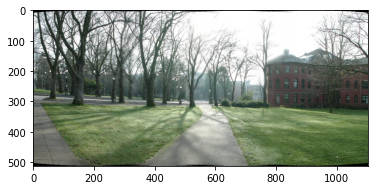

In [106]:
result = np.zeros((result_height, result_width, 3))

for i in range(len(result_images)):
    img = np.float32(np.copy(result_images[i]))
    width = img.shape[1]
    height = img.shape[0]
    shift_x = accum_shifts[i][0]
    shift_y = accum_shifts[i][1]

    mask = np.ones((height, width), dtype=np.float32)
    if i > 0:
        overlap = width - (shift_x - accum_shifts[i-1][0])
        mask[:, :overlap] = mask[:, :overlap] * np.linspace(0, 1, overlap)
    if i < len(result_images)-1:
        overlap = width - (accum_shifts[i+1][0] - shift_x)
        mask[:, -overlap:] = mask[:, -overlap:] * np.linspace(1, 0, overlap)
    result[shift_y: shift_y+height, shift_x: shift_x+width] += img * mask.reshape(height, width, 1)

plt.imshow(cv2.cvtColor(np.uint8(result), cv2.COLOR_BGR2RGB))

In [13]:
# import numpy as np
# import cv2 as cv
# from matplotlib import pyplot as plt
# MIN_MATCH_COUNT = 10
# img1 = gray_images[0]         # queryImage
# img2 = gray_images[1] # trainImage
# # Initiate SIFT detector
# sift = cv.SIFT_create()
# # find the keypoints and descriptors with SIFT
# kp1, des1 = sift.detectAndCompute(gray_images[0],None)
# kp2, des2 = sift.detectAndCompute(gray_images[1],None)
# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# search_params = dict(checks = 50)
# flann = cv.FlannBasedMatcher(index_params, search_params)
# matches = flann.knnMatch(des1,des2,k=2)
# # store all the good matches as per Lowe's ratio test.
# good = []
# for m,n in matches:
#     if m.distance < 0.7*n.distance:
#         good.append(m)

# if len(good)>MIN_MATCH_COUNT:
#     src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
#     dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
#     M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
#     matchesMask = mask.ravel().tolist()
#     h,w = img1.shape
#     pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
#     dst = cv.perspectiveTransform(pts,M)
#     img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
# else:
#     print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
#     matchesMask = None

# draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                    singlePointColor = None,
#                    matchesMask = matchesMask, # draw only inliers
#                    flags = 2)
# img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
# plt.imshow(img3, 'gray'),plt.show()